## Analysis of video game sales

-  Client: A major video game production company

-  Goal: conduct market research into the video game industry

- Question they have: 

What are some major differences between the North American, European, and Japanese video game markets?

What video game genres are trending in each market?

What features about a video game are most indicative of its success?

In [178]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, metrics

%matplotlib inline

Import dataset, initial exploration

In [108]:
data = pd.read_csv('vgsales.csv')
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [3]:
print('Number of games in the dataset is {}\nNumber of columns is {}'.format(data.shape[0], data.shape[1]))

Number of games in the dataset is 16598
Number of columns is 11


In [4]:
if data.isnull().values.any():
    print('There are null values in the data.')

There are null values in the data.


In [5]:
for column in data.columns:
    if data[column].isnull().any():
        print('Column "{}" has null values'.format(column))

Column "Year" has null values
Column "Publisher" has null values


In [6]:
# Grab lists of unique values for publishers, genres, and platforms
publishers = data['Publisher'].unique()
genres = data['Genre'].unique()
platforms = data['Platform'].unique()

In [7]:
regions = ['NA_Sales', 'EU_Sales', 'JP_Sales']

In [8]:
max_sales_in_market = []
for region in regions:
    max_sales_in_market.append(data[region].max())

max_sales = max(max_sales_in_market)
print('The max sales for a single video game in a single region is {}'.format(max(max_sales_in_market)))

The max sales for a single video game in a single region is 41.49


In [9]:
sales_data = {}
for region in regions:
    sales_list = []
    for sales_bin in range(1, int(max_sales)):
        sales_list.append(data[data[region] > sales_bin].shape[0])
    sales_data[region] = sales_list

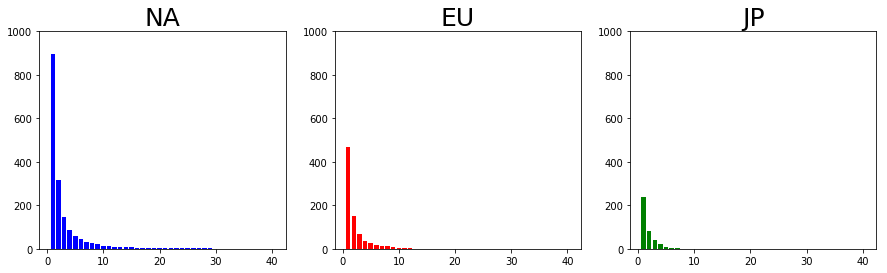

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
colors = ['b', 'r', 'g']
titles = ['NA', 'EU', 'JP']

for index in range(3):
    axs[index].bar(range(1, int(max_sales)), sales_data[regions[index]], color=colors[index])
    axs[index].set_ylim(0,1000)
    axs[index].set_title(titles[index], fontsize=25)
fig.savefig('vgsales_across_markets.pdf')

The NA market is bigger than the EU market, which is bigger than the JP market.
How big each market is in $, i.e., sales?

In [11]:
NA_sales = data['NA_Sales'].sum()
EU_sales = data['EU_Sales'].sum()
JP_sales = data['JP_Sales'].sum()
print('NA, EU, and JP sales over all games in the dataset are:\
 {:.0f}, {:.0f}, and {:.0f} millions of dollars, respectively.'.format(NA_sales, EU_sales, JP_sales))

NA, EU, and JP sales over all games in the dataset are: 4393, 2434, and 1291 millions of dollars, respectively.


In [12]:
vg_data = data.copy()
vg_data.dropna(subset=['Year'], inplace=True)
#vg_data.head()

In [13]:
vg_data['Year'].max(), vg_data['Year'].min()

(2020.0, 1980.0)

In [14]:
year_ranges = np.arange(1980, 2020, 5)
#year_ranges

In [15]:
def year_bin(row, year_ranges):
    for year in year_ranges:
        if row >= year and row < year+5:
            return year

In [16]:
vg_data['Year'] = vg_data['Year'].apply(year_bin, year_ranges=year_ranges)

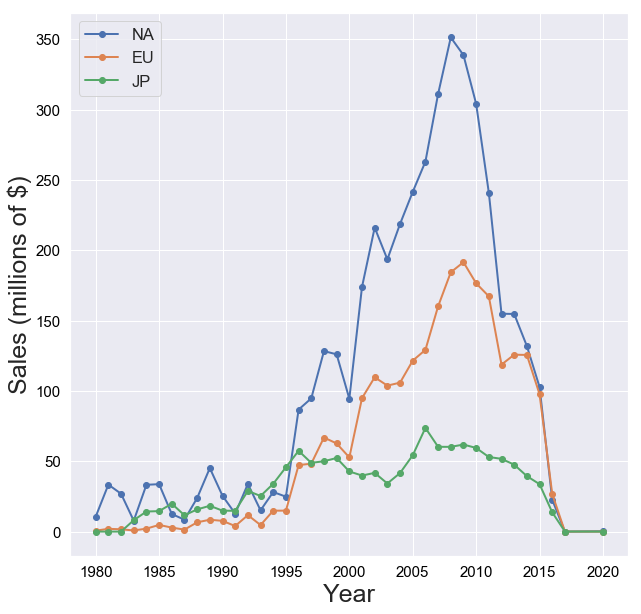

In [274]:
vg_sales = vg_data.groupby('Year')[['NA_Sales', 'EU_Sales', 'JP_Sales']].sum()
plt.figure(figsize=(10,10))
plt.plot(vg_sales, linewidth=2, marker = 'o')
plt.legend(['NA', 'EU', 'JP'], loc = 'upper left')
axis_tick_font = {'size':'15', 'color':'black'}
plt.xlabel('Year', fontsize=25)
plt.ylabel('Sales (millions of $)', fontsize=25)
plt.xticks(**axis_tick_font)
plt.yticks(**axis_tick_font)
plt.savefig('vgsales_across_markets_over_time.pdf')

In [18]:
yearly_total_sales = vg_data.groupby('Year')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().sum(axis=1)

In [19]:
vg_data.groupby('Year')[['NA_Sales', 'EU_Sales', \
            'JP_Sales', 'Other_Sales']].sum().divide(yearly_total_sales/100, axis='rows')

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Year,,,,
1980.0,78.237473,5.017821,15.633517,1.111189
1985.0,53.005699,10.291786,34.328806,2.373709
1990.0,40.770454,15.133416,41.664605,2.431525
1995.0,46.270260,24.106730,25.551829,4.071180
2000.0,52.849139,27.485847,11.747382,7.917632
2005.0,51.365482,26.828363,10.574054,11.232101
2010.0,45.178448,32.700591,11.503797,10.617164
2015.0,37.436601,37.135271,14.162540,11.265589


In [20]:
data_na = data.sort_values(by='NA_Sales', ascending=False) #sort by na_sales
data_eu = data.sort_values(by='EU_Sales', ascending=False) #sort by eu_sales
data_jp = data.sort_values(by='JP_Sales', ascending=False) #sort by jp_sales

na_top_platforms = data_na.iloc[:100].groupby('Platform')['Platform'].count()
eu_top_platforms = data_eu.iloc[:100].groupby('Platform')['Platform'].count() 
jp_top_platforms = data_jp.iloc[:100].groupby('Platform')['Platform'].count() 

top_platforms = pd.DataFrame([na_top_platforms, eu_top_platforms, jp_top_platforms], index=['NA', 'EU', 'JP'])

In [21]:
top_platforms.T.head()

,NA,EU,JP
2600,3.0,NaN,NaN
3DS,4.0,5.0,15.0
DS,9.0,13.0,17.0
GB,6.0,4.0,10.0
GBA,2.0,2.0,3.0


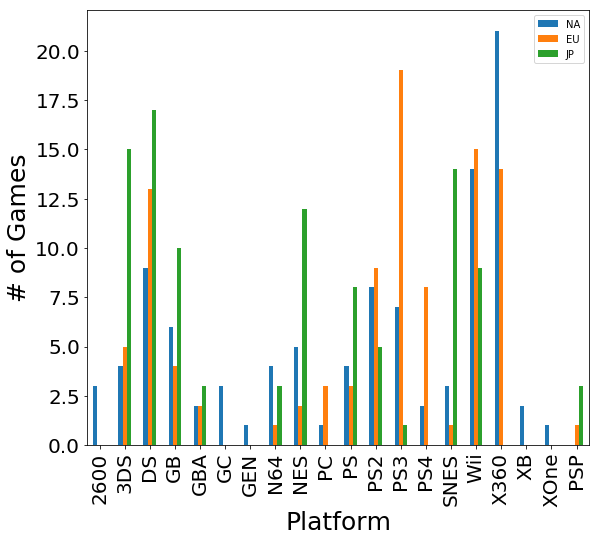

In [32]:
top_platforms.T.plot.bar(figsize = (9,8), fontsize = 20)
plt.xlabel('Platform', fontsize=25)
plt.ylabel('# of Games', fontsize=25)
plt.savefig('consoles_across_markets.pdf')

In [93]:
df_naplat = vg_data.groupby(['Platform']).sum()['NA_Sales'].sort_values(ascending=False).head(10)
df_euplat = vg_data.groupby(['Platform']).sum()['EU_Sales'].sort_values(ascending=False).head(10)
df_jpplat = vg_data.groupby(['Platform']).sum()['JP_Sales'].sort_values(ascending=False).head(10)

top_plat = list(set(list(df_naplat.index.values) + list(df_euplat.index.values) + list(df_jpplat.index.values)))
df_top_plat = vg_data.groupby(['Platform']).sum().apply(lambda x: x/sum(x)*100).loc[top_plat].sort_values('NA_Sales',ascending=False)

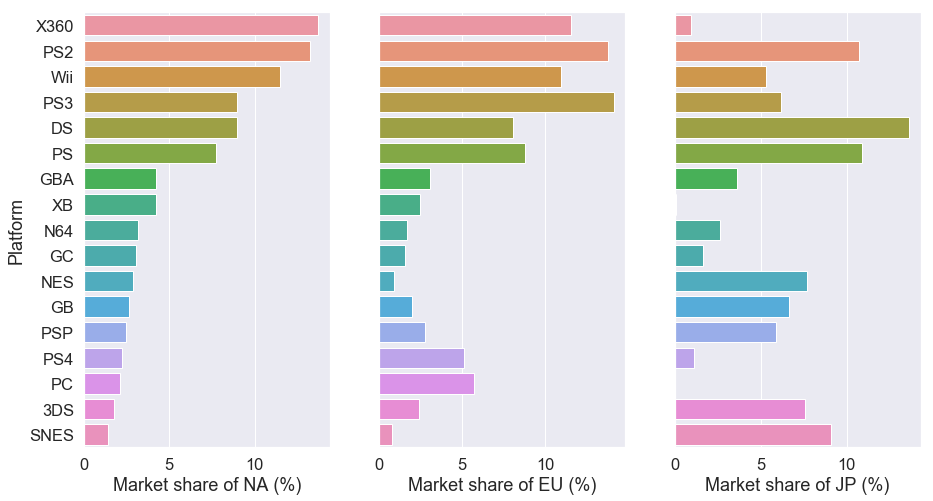

In [277]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)

plt.subplot(1,3,1)
sns.barplot(data=df_top_plat,x='NA_Sales',y=df_top_plat.index)
plt.xlabel('Market share of NA (%)')

plt.subplot(1,3,2)
ax = sns.barplot(data=df_top_plat,x='EU_Sales',y=df_top_plat.index)
ax.set_yticks([])
plt.xlabel('Market share of EU (%)')
plt.ylabel('')

plt.subplot(1,3,3)
ax = sns.barplot(data=df_top_plat,x='JP_Sales',y=df_top_plat.index)
ax.set_yticks([])
plt.xlabel('Market share of JP (%)')
plt.ylabel('')
fig.savefig('platforms_across_market.pdf')

top 10 platforms

In [87]:
top_napub = vg_data.groupby(['Publisher']).sum()['NA_Sales'].sort_values(ascending=False).head(10)
top_eupub = vg_data.groupby(['Publisher']).sum()['EU_Sales'].sort_values(ascending=False).head(10)
top_jppub = vg_data.groupby(['Publisher']).sum()['JP_Sales'].sort_values(ascending=False).head(10)
top_pub = list(set(list(top_napub.index.values) + list(top_eupub.index.values) + list(top_jppub.index.values)))
df_top_pub = vg_data.groupby(['Publisher']).sum().apply(lambda x: x/sum(x)*100).loc[top_pub].sort_values('NA_Sales', ascending=False)

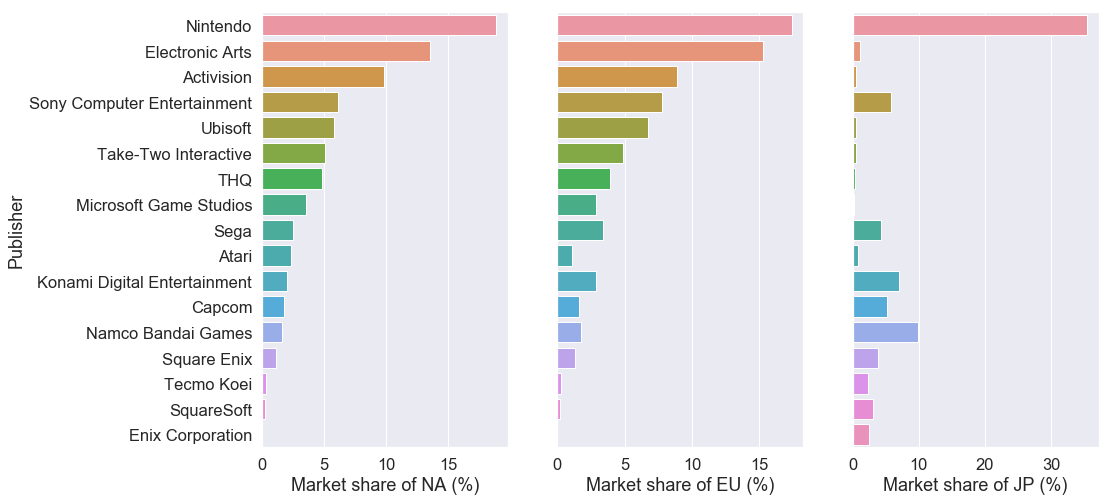

In [97]:
fig = plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)

plt.subplot(1,3,1)
sns.barplot(data=df_top_pub,x='NA_Sales',y=df_top_pub.index)
plt.xlabel('Market share of NA (%)')

plt.subplot(1,3,2)
ax = sns.barplot(data=df_top_pub,x='EU_Sales',y=df_top_pub.index)
ax.set_yticks([])
plt.xlabel('Market share of EU (%)')
plt.ylabel('')

plt.subplot(1,3,3)
ax = sns.barplot(data=df_top_pub,x='JP_Sales',y=df_top_pub.index)
ax.set_yticks([])
plt.xlabel('Market share of JP (%)')
plt.ylabel('')
fig.savefig('publisher_across_market.pdf')

genre distribution

In [98]:
df_genre = vg_data.groupby('Genre').sum()
df_genre.sort_values(by=['NA_Sales'],inplace = True,ascending=True)

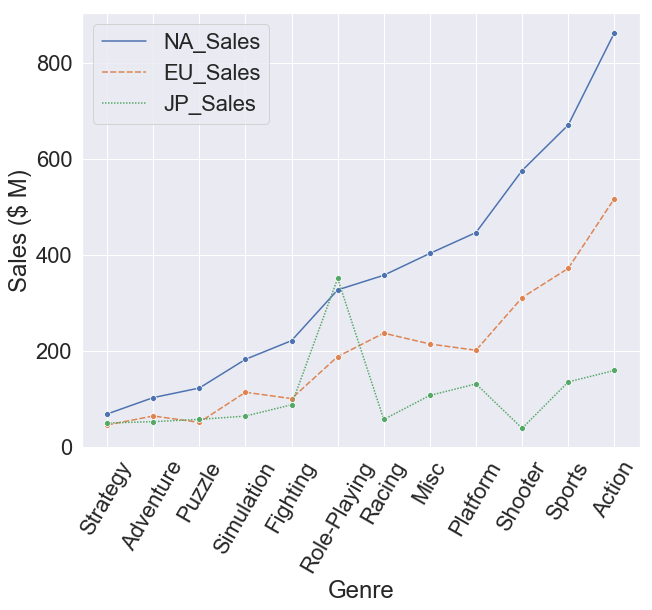

In [278]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=2)
ax = sns.lineplot(data = df_genre[['NA_Sales','EU_Sales','JP_Sales']],sort=False,marker='o')
plt.xticks(rotation=60)
plt.ylabel('Sales ($ M)')
plt.savefig('genres.pdf')

### Summary:
-  #### NA vs EU:
NA and EU market are very similar in the overall market landscape and genre popularity. 
Top video game publishers and major platforms in these two are similar, except PC and PS4 are more popular in EU.

-  #### JP  vs  NA-EU
The market landscape in Japan is different from both NA and EU:

Nintendo dominates market share. 

Some less popular platform in NA and EU are popular in Japan.

Role-playing is the most popular genre in JP market.

In [168]:
cm = plt.get_cmap('tab20')
color_dict = {}
for index in range(len(platforms)):
    color_dict[platforms[index]] = cm(index)

In [169]:
df_year_genre_na = data.groupby(['Genre','Year'],as_index=False).sum().pivot(index='Year',columns='Genre',values='NA_Sales')

### Deal with missing data
# since analyzing the trending genre, I dropped the NaN for years before 1991. 
# Data for 2017 and 2020 are mostly NaN. I dropped these.
# Data for 2016 is the most latest data we have. I decide to fill the only NaN using value from 2015.

df_year_genre_na.loc[2016].fillna(df_year_genre_na.loc[2015],inplace=True)
df_year_genre_na.dropna(inplace=True)

In [170]:
df_year_genre_na.columns.values

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

<Figure size 1080x576 with 0 Axes>

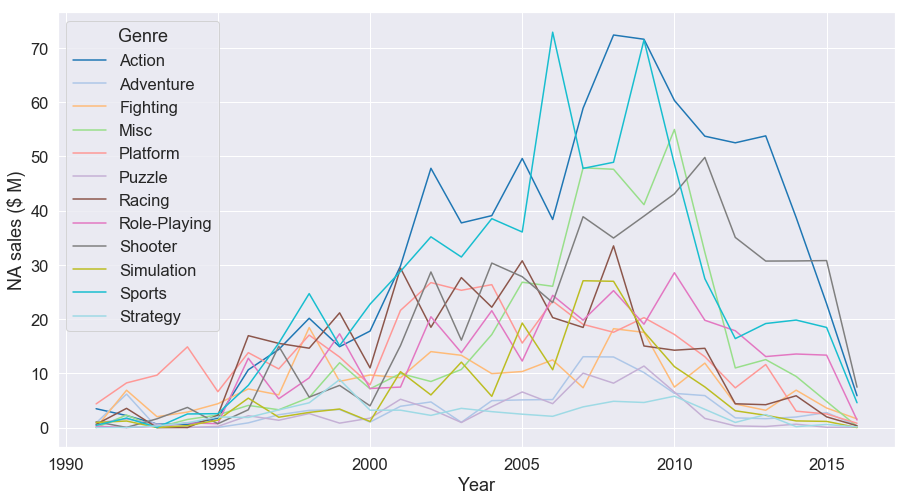

In [173]:
df = df_year_genre_na[df_year_genre_na.columns.values]
fig = plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)

df.plot(y = df_year_genre_na.columns.values, colormap = cm)
plt.ylabel('NA sales ($ M)')
fig.savefig('nagenre.pdf')

In [174]:
df_year_genre_eu = data.groupby(['Genre','Year'],as_index=False).sum().pivot(index='Year',columns='Genre',values='EU_Sales')

df_year_genre_eu.loc[2016].fillna(df_year_genre_eu.loc[2015],inplace=True)
df_year_genre_eu.dropna(inplace=True)

<Figure size 1080x576 with 0 Axes>

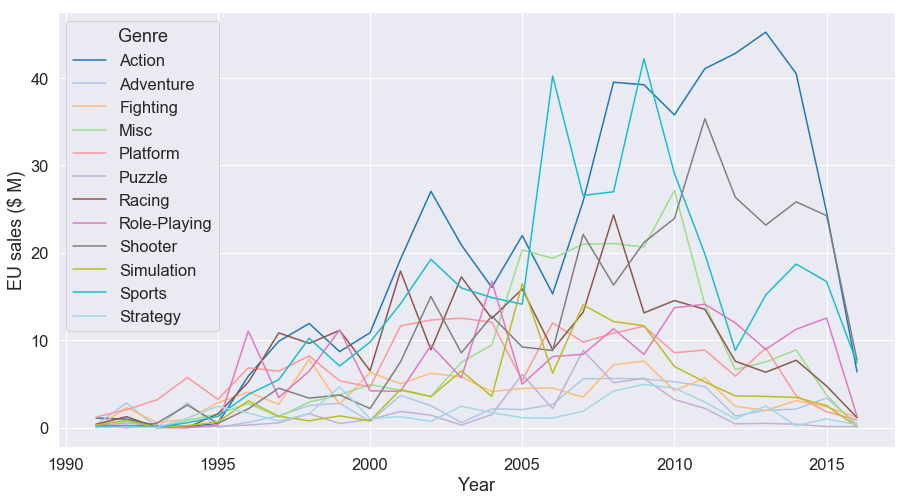

In [175]:
df = df_year_genre_eu[df_year_genre_eu.columns.values]
fig = plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)

df.plot(y = df_year_genre_eu.columns.values, colormap = cm)
plt.ylabel('EU sales ($ M)')
fig.savefig('eugenre.pdf')

In [176]:
df_year_genre_jp = data.groupby(['Genre','Year'],as_index=False).sum().pivot(index='Year',columns='Genre',values='JP_Sales')

df_year_genre_jp.loc[2016].fillna(df_year_genre_jp.loc[2015],inplace=True)
df_year_genre_jp.dropna(inplace=True)

<Figure size 1080x576 with 0 Axes>

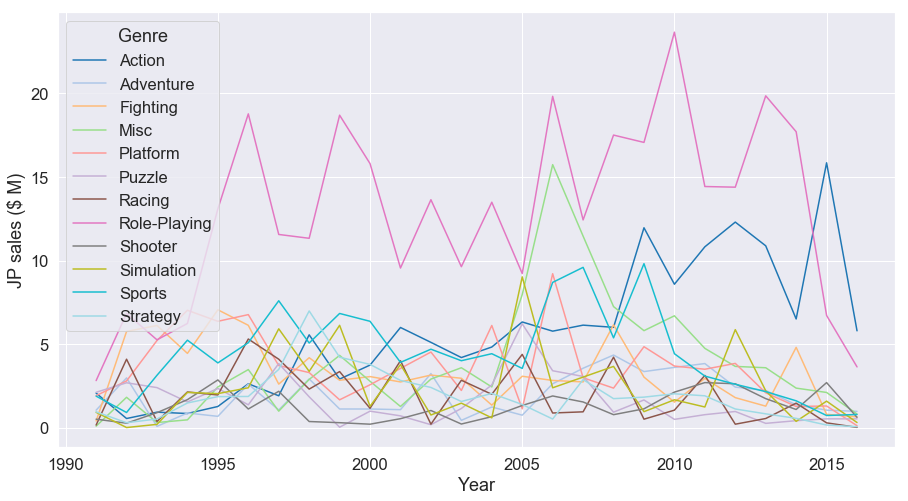

In [177]:
df = df_year_genre_jp[df_year_genre_jp.columns.values]
fig = plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)

df.plot(y = df_year_genre_jp.columns.values, colormap = cm)
plt.ylabel('JP sales ($ M)')
fig.savefig('jpgenre.pdf')

#### The indicative features of a successful video game could be the features with high feature importance from predictive model of the sales.
Current features we have about video games including name, publishing platform, publisher, genre.

In [179]:
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


Let's predict global_sales using platform, year, genre, and publisher data using a linear regression.
    - Platform is categorical and will need to be One hot coding (OHE)
    - Year is ordinal and can be normalized by dividing by the max (in order to maintain ratios between years) 
    - Genre is categorical and will need to be OHE
    - Publisher is categorical and will need to be OHE
    
Notably we don't want to use NAsales, EUsales, or JPsales as predictors, since they are obviously TOO correlated with global sales.

In [180]:
vg_data = data.dropna(subset=['Year', 'Publisher', 'Platform', 'Genre'], axis=0)

In [181]:
platforms_encoded = pd.get_dummies(vg_data['Platform'].values)
platforms_encoded = platforms_encoded.reset_index().drop(labels='index', axis=1)

In [182]:
genres_encoded = pd.get_dummies(vg_data['Genre'].values) 
genres_encoded = genres_encoded.reset_index().drop(labels='index', axis=1)

In [183]:
publishers_encoded = pd.get_dummies(vg_data['Publisher'].values)
publishers_encoded = publishers_encoded.reset_index().drop(labels='index', axis=1)

In [184]:
year = vg_data['Year']/2020
year = year.reset_index().drop(labels='index', axis=1)

In [185]:
model_data = pd.concat([platforms_encoded, genres_encoded, publishers_encoded, year], axis=1)
target = vg_data['Global_Sales']

In [252]:
X_train, X_test, y_train, y_test = train_test_split(model_data, target, test_size=0.30, random_state=0)

In [253]:
X_train.shape

(11403, 620)

In [261]:
clf = LinearRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred

array([ 5.56640625e-01,  6.25000000e-02, -1.23046875e-01, ...,
        7.95567608e+12,  2.13183594e+00, -3.24218750e-01])

In [262]:
clf.score(X_test, y_test)

-3.7023152610252696e+24

In [263]:
metrics.r2_score(y_test.values, y_pred)

-3.7023152610252696e+24

In [264]:
#pretty bad score

In [265]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [260]:
clf.score(X_test, y_test)

-0.3037569956144459

In [266]:
n_estimators = [10, 25, 50, 100] # number of trees
min_samples_split = [2, 10, 25, 50] # minimum number of samples needed to split a node

hp_list = []
for estimator in n_estimators:
    for sample in min_samples_split:
        clf = RandomForestRegressor(n_estimators=estimator, min_samples_split=sample)
        clf.fit(X_train, y_train)
        hp_list.append([estimator, sample, clf.score(X_test, y_test)])
        print('done')

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [267]:
sorted(hp_list, key=lambda x: x[2], reverse=True) # largest accuracies shown first

[[100, 50, 0.18823038517436408],
 [10, 50, 0.18676643629060208],
 [25, 50, 0.17831898530498425],
 [50, 50, 0.17687880546853718],
 [25, 25, 0.14096940197033336],
 [50, 25, 0.1348415158099472],
 [100, 25, 0.09813487417076783],
 [10, 25, 0.0554020488162118],
 [50, 10, -0.023415371977004273],
 [100, 10, -0.03605440281320571],
 [10, 10, -0.1094155986601606],
 [10, 2, -0.11584923972189576],
 [100, 2, -0.17050271789530935],
 [25, 10, -0.17231218354943234],
 [50, 2, -0.1756514711856909],
 [25, 2, -0.23127340044238645]]

The best R^2 score is achieved for n_estimators = 10, min_samples_split = 25, with R^2=0.17. This is much better than linear regression, suggesting that the underlying function may not be linear.

Let's refit the best model and see what the top predictors are

In [268]:
clf = RandomForestRegressor(n_estimators=10, min_samples_split=25)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=25,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [269]:
clf.score(X_test, y_test)

0.1539212225611426

In [270]:
top_predictors = (-clf.feature_importances_).argsort()[:20]
X_train.iloc[:, top_predictors].columns

Index(['Nintendo', 'Year', 'Sports', 'Wii', 'Racing', 'Shooter',
       'Role-Playing', 'GB', 'Platform', 'X360', 'Simulation', 'Action',
       'Microsoft Game Studios', 'PS3', 'Electronic Arts', 'PS2',
       'Sony Computer Entertainment', 'DS', 'Fighting', 'GBA'],
      dtype='object')

In [271]:
for name in X_train.iloc[:, top_predictors].columns:
    if name in publishers:
        print('publisher')
    elif name in genres:
        print('genres')
    elif name in platforms:
        print('platform')
    else:
        print('year')

publisher
year
genres
platform
genres
genres
genres
platform
genres
platform
genres
genres
publisher
platform
publisher
platform
publisher
platform
genres
platform


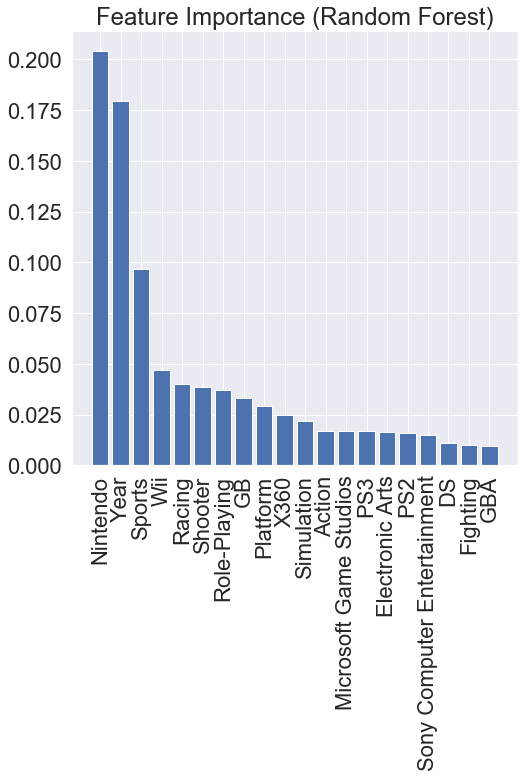

In [284]:
plt.figure(figsize=(8,8))
plt.bar(x=range(20), height=clf.feature_importances_[top_predictors],\
        tick_label=X_train.iloc[:, top_predictors].columns)
plt.xticks(rotation=90)
plt.title('Feature Importance (Random Forest)');
plt.savefig('rf_featureimportance.png')

### Summary:
The market size of video game now reduced from its peak at 2009. 

The features provided by this data set are not quite enough to predict the success of a video game. With current features, the error is high.

For a video game production company, what they can do is picking the trending genre and publish their games on the right platform or more platforms.